#### This notebook finds a dynamic factorization of transition dynamics / SCM.

Unfortunately there are many loss terms, and it is quite brittle to hparams.

Maybe there is a better way to do statistical independence test than learning to predict next step using squared error loss.

In [8]:
import numpy as np
np.random.seed(2)
import torch
from structured_transitions import gen_samples_dynamic, TransitionsData, MixtureOfMaskedNetworks

In [9]:
BATCH_SIZE = 1000
MASK_REGULARIZATION_COEFFICIENT = 1e-3
WEIGHT_LOSS_COEFFICIENT = 1e-3
ATTENTION_LOSS_COEFFICIENT = 1e-3
WEIGHT_DECAY = 1e-5
SPLITS = [4,3,2] # this is the factorization
dev = 'cuda' if torch.cuda.is_available() else 'cpu'

global_interactions, fns, samples = gen_samples_dynamic(num_seqs=1500, seq_len=10, 
                                                        splits=SPLITS, epsilon=1.5) # 15000 samples
print('Total global interactions: {}/{}'.format(global_interactions, len(samples[0])))
dataset = TransitionsData(samples)
tr = TransitionsData(dataset[:int(len(dataset)*5/6)])
te = TransitionsData(dataset[int(len(dataset)*5/6):])

train_loader = torch.utils.data.DataLoader(tr, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
test_loader  = torch.utils.data.DataLoader(te, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, drop_last=True)

Total global interactions: 2369.0/15000


In [10]:
model = MixtureOfMaskedNetworks(in_features=sum(SPLITS), out_features=sum(SPLITS), num_components=3,
                      num_hidden_layers=2, num_hidden_units=256).to(dev)

opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=WEIGHT_DECAY)
pred_criterion = torch.nn.MSELoss()
mask_criterion = torch.nn.L1Loss()

for epoch in range(500):
  total_pred_loss, total_mask_loss, total_weight_loss, total_attn_loss = 0., 0., 0., 0.
  for i, (x, y) in enumerate(train_loader):
    pred_y, mask, attn = model.forward_with_mask(x.to(dev))
    pred_loss = pred_criterion(y.to(dev), pred_y)
    mask_loss = MASK_REGULARIZATION_COEFFICIENT * mask_criterion(torch.log(1.+mask), torch.zeros_like(mask)) 
    attn_loss = ATTENTION_LOSS_COEFFICIENT * torch.sqrt(attn).mean()
    
    weight_loss = 0
    for param in model.parameters():
      weight_loss += mask_criterion(param, torch.zeros_like(param))
    weight_loss *= WEIGHT_LOSS_COEFFICIENT
    
    total_pred_loss += pred_loss
    total_mask_loss += mask_loss
    total_attn_loss += attn_loss
    total_weight_loss += weight_loss
    
    loss = pred_loss + mask_loss + attn_loss + weight_loss
    model.zero_grad()
    loss.backward()
    opt.step()
  if epoch % 25 == 0:
    print('Epoch {} done! Pred: {:.5f}, Mask: {:.5f}, Attn: {:.5f}, Weight: {:.5f}'.\
        format(epoch, total_pred_loss / i, total_mask_loss / i, total_attn_loss / i, total_weight_loss / i))

Epoch 0 done! Pred: 0.01926, Mask: 0.00266, Attn: 0.00063, Weight: 0.00192
Epoch 25 done! Pred: 0.00102, Mask: 0.00112, Attn: 0.00063, Weight: 0.00094
Epoch 50 done! Pred: 0.00099, Mask: 0.00049, Attn: 0.00063, Weight: 0.00055
Epoch 75 done! Pred: 0.00092, Mask: 0.00030, Attn: 0.00062, Weight: 0.00040
Epoch 100 done! Pred: 0.00083, Mask: 0.00023, Attn: 0.00061, Weight: 0.00032
Epoch 125 done! Pred: 0.00076, Mask: 0.00018, Attn: 0.00056, Weight: 0.00027
Epoch 150 done! Pred: 0.00069, Mask: 0.00014, Attn: 0.00049, Weight: 0.00025
Epoch 175 done! Pred: 0.00064, Mask: 0.00013, Attn: 0.00046, Weight: 0.00023
Epoch 200 done! Pred: 0.00060, Mask: 0.00013, Attn: 0.00045, Weight: 0.00022
Epoch 225 done! Pred: 0.00058, Mask: 0.00013, Attn: 0.00044, Weight: 0.00021
Epoch 250 done! Pred: 0.00055, Mask: 0.00013, Attn: 0.00044, Weight: 0.00021
Epoch 275 done! Pred: 0.00054, Mask: 0.00013, Attn: 0.00044, Weight: 0.00020
Epoch 300 done! Pred: 0.00052, Mask: 0.00013, Attn: 0.00043, Weight: 0.00020
Epoc

In [13]:
for c in model.components:
  m = c.mask.detach().cpu().numpy()
  m[m < 0.01] = 0
  print(m.round(2))
  print('*')

[[0.04 0.02 0.   0.02 0.   0.   0.   0.   0.01]
 [0.14 0.19 0.02 0.16 0.   0.   0.   0.   0.03]
 [0.12 0.33 0.   0.3  0.   0.   0.   0.02 0.13]
 [0.12 0.11 0.01 0.08 0.   0.   0.01 0.   0.02]
 [0.02 0.   0.   0.   0.41 0.11 0.12 0.   0.02]
 [0.02 0.   0.   0.   0.03 0.02 0.06 0.   0.01]
 [0.   0.   0.   0.   0.07 0.02 0.05 0.   0.  ]
 [0.   0.01 0.   0.   0.   0.   0.   0.49 1.64]
 [0.   0.01 0.   0.   0.   0.   0.   0.87 1.64]]
*
[[0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
*
[[0.32 0.86 0.42 0.45 0.86 0.62 0.67 0.27 0.63]
 [0.33 0.89 0.42 0.44 0.92 0.63 0.74 0.21 0.69]
 [0.32 0.85 0.39 0.45 0.88 0.62 0.66 0.22 0.61]
 [0.36 0.9  0.45 0.48 0.94 0.62 0.77 0.23 0.7 ]
 [0.41 0.46 0.28 0.27 0.88 0.65 0.83 0.27 0.71]
 [0.43 0.44 0.3  0.24 0.77 0.69 0.83 0.31 0.73]
 [0.

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

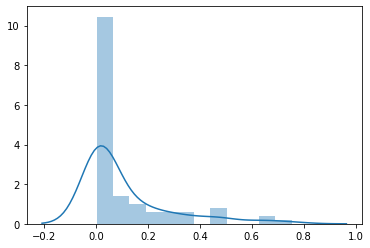

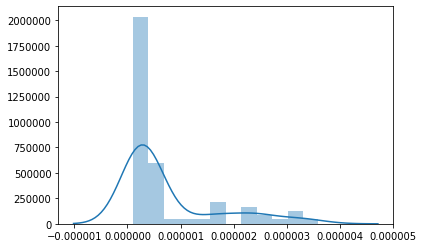

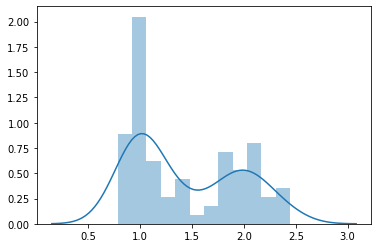

In [9]:
for c in model.components:
  m = c.mask.detach().cpu().numpy()
  sns.distplot(m.reshape(-1), bins=12)
  plt.show()